In [ ]:
## Install ultralytics
!pip install ultralytics

In [2]:
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.208 🚀 Python-3.10.12 torch-2.1.0+cu118 CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 27.0/107.7 GB disk)


In [3]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import random
import os
import cv2
import shutil
import tqdm
import glob
import time

In [36]:
# Check GPU is working or not
import torch
print(f"Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Using torch 2.1.0+cu118 (CPU)


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/CMPE_258/258_HW/archive_fashion.zip

In [12]:
images_path = '/content/colorful_fashion_dataset_for_object_detection/JPEGImages/'
annotations_path  = '/content/colorful_fashion_dataset_for_object_detection/Annotations_txt/'
path = '/content/colorful_fashion_dataset_for_object_detection/'

# Pre-trained YOLOv8 for Object Detection

In [7]:
from ultralytics import YOLO

# load pre-trained model
detection_model = YOLO("yolov8m.pt")

100%|██████████| 49.7M/49.7M [00:00<00:00, 143MB/s]


# Prepare Dataset
### Dataset: colorful_fashion_dataset_for_object_detection
#### Source Kaggle

In [13]:
train = []
with open(path+'ImageSets/Main/trainval.txt', 'r') as f:
    for line in f.readlines():
        if line[-1]=='\n':
            line = line[:-1]
        train.append(line)

test = []
with open(path+'ImageSets/Main/test.txt', 'r') as f:
    for line in f.readlines():
        if line[-1]=='\n':
            line = line[:-1]
        test.append(line)

In [14]:
len(train), len(test)

(2145, 537)

In [15]:
os.mkdir('train')
os.mkdir('train/images')
os.mkdir('train/labels')

os.mkdir('test')
os.mkdir('test/images')
os.mkdir('test/labels')

In [16]:
train_path = '/content/train/'
test_path = '/content/test/'

print('Copying Train Data..!!')
for i in tqdm.tqdm(train):
    a = shutil.copyfile(images_path+i+'.jpg', train_path+'images/'+i+'.jpg')
    a = shutil.copyfile(annotations_path+i+'.txt', train_path+'labels/'+i+'.txt')

print('Copying Test Data..!!')
for i in tqdm.tqdm(test):
    a = shutil.copyfile(images_path+i+'.jpg', test_path+'images/'+i+'.jpg')
    a = shutil.copyfile(annotations_path+i+'.txt', test_path+'labels/'+i+'.txt')

Copying Train Data..!!


100%|██████████| 2145/2145 [00:00<00:00, 2862.24it/s]


Copying Test Data..!!


100%|██████████| 537/537 [00:00<00:00, 2800.95it/s]


# Train Custom Model

In [17]:
text = """
train: /content/train
val: /content/test

# number of classes
nc: 10

# class names
names: ['sunglass','hat','jacket','shirt','pants','shorts','skirt','dress','bag','shoe']
"""
with open("data.yaml", 'w') as file:
    file.write(text)

In [18]:
# Load the file to inspect its contents
checkpoint = torch.load('/content/yolov8m.pt')

# Print out the keys and data types of the contents
for key, value in checkpoint.items():
    print(f"Key: {key}, Type: {type(value)}")

Key: epoch, Type: <class 'int'>
Key: best_fitness, Type: <class 'NoneType'>
Key: model, Type: <class 'ultralytics.nn.tasks.DetectionModel'>
Key: ema, Type: <class 'NoneType'>
Key: updates, Type: <class 'NoneType'>
Key: optimizer, Type: <class 'NoneType'>
Key: train_args, Type: <class 'dict'>
Key: date, Type: <class 'str'>
Key: version, Type: <class 'str'>


In [54]:
file_size_bytes = os.path.getsize('/content/yolov8m.pt')
file_size_mb = file_size_bytes / (2**20)

print(f"The file size of the pre-trained YOLOv8 model is {file_size_mb:.2f} MB.")

The file size of the pre-trained YOLOv8 model is 49.70 MB.


In [22]:
model = YOLO("yolov8m.pt")
start_time = time.time()
model.train(data='data.yaml', epochs=5, batch=8, imgsz=128)
end_time = time.time()
time_elapsed = end_time - start_time
print("Time elapsed: ", time_elapsed)

Ultralytics YOLOv8.0.208 🚀 Python-3.10.12 torch-2.1.0+cu118 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=data.yaml, epochs=5, patience=50, batch=8, imgsz=128, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=Fals

Time elapsed:  3625.9400141239166


In [37]:
# Load the checkpoint file
baseline = torch.load('/content/runs/detect/train2/weights/best.pt')

# The model is stored directly under the 'model' key
model_bsl = baseline['model']

# Put the model in evaluation mode
model_bsl.eval()

DetectionModel(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(48, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(96, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (2): C2f(
      (cv1): Conv(
        (conv): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(96, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(96, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
   

In [55]:
file_size_bytes = os.path.getsize('/content/runs/detect/train2/weights/best.pt')
file_size_mb = file_size_bytes / (2**20)

print(f"The file size of the custom YOLOv8 model is {file_size_mb:.2f} MB.")

The file size of the custom YOLOv8 model is 49.58 MB.


In [ ]:
# Load the unoptimized baseline model file
checkpoint = torch.load('/content/runs/detect/train2/weights/best.pt')

# The model is stored directly under the 'model' key
model_bsl = checkpoint['model']

# Convert model to full precision (FP32)
model_bsl.float()

# Put the model in evaluation mode
model_bsl.eval()

In [49]:
!pip install onnx
!pip install onnxruntime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 69.8 MB/s eta 0:00:00


In [76]:
from PIL import Image
from torchvision import transforms

# Load an image
image_path = '/content/test/images/10226.jpg'
image = Image.open(image_path).convert('RGB')

# Define the standard YOLOv8 preprocessing transformations
# These values (mean and std) should be the ones used during the training of your model
preprocess = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize the image to the size your model expects
    transforms.ToTensor(),          # Convert the image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize the image
])

# Apply the preprocessing to the image
input_tensor = preprocess(image)

# Add a batch dimension by using 'unsqueeze'
input_tensor = input_tensor.unsqueeze(0)


In [77]:
# If using a GPU, transfer the model and input tensor to the GPU
# Otherwise, make sure both are on the CPU
if torch.cuda.is_available():
    model_bsl.cuda()
    input_tensor = input_tensor.cuda()
    print("GPU")
else:
    model_bsl.cpu()
    input_tensor = input_tensor.cpu()
    print("CPU")

# Perform inference in full precision
with torch.no_grad():
    start_time = time.time()
    outputs = model_bsl(input_tensor)
    end_time = time.time()

# Calculate the inference time
inference_time = end_time - start_time
print(f"Inference Time: {inference_time:.6f} seconds")

CPU
Inference Time: 0.315691 seconds


In [80]:
# Convert to TorchScript using tracing
# Note: Tracing records the operations as they are executed on the provided input tensor
scripted_model = torch.jit.trace(model_bsl, input_tensor, strict=False)
scripted_model.save('fashion_yolov8_torchscript_model_1.pt')

# Benchmark the inference time for TorchScript model
with torch.no_grad():
    start_time = time.time()
    outputs = scripted_model(input_tensor)
    end_time = time.time()

torchscript_inference_time = end_time - start_time
print(f"TorchScript Inference Time: {torchscript_inference_time:.6f} seconds")

/usr/local/lib/python3.10/dist-packages/ultralytics/nn/modules/head.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  elif self.dynamic or self.shape != shape:


TorchScript Inference Time: 0.278856 seconds


In [83]:
file_size_bytes = os.path.getsize('/content/fashion_yolov8_torchscript_model_1.pt')
file_size_mb = file_size_bytes / (2**20)

print(f"The file size of the TorchScript model is {file_size_mb:.2f} MB.")

The file size of the TorchScript model is 99.51 MB.


In [81]:
import onnxruntime
import numpy as np

# Export the model to ONNX format
torch.onnx.export(model_bsl, input_tensor, 'fashion_yolov8_model_1.onnx', export_params=True, opset_version=11)

# Load the ONNX model with ONNX Runtime
ort_session = onnxruntime.InferenceSession('fashion_yolov8_model_1.onnx')

# Convert the input to a format that ONNX Runtime understands
def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(input_tensor)}

# Benchmark the inference time for ONNX model
start_time = time.time()
ort_outs = ort_session.run(None, ort_inputs)
end_time = time.time()

onnx_inference_time = end_time - start_time
print(f"ONNX Inference Time: {onnx_inference_time:.6f} seconds")

ONNX Inference Time: 0.070989 seconds


In [82]:
file_size_bytes = os.path.getsize('/content/fashion_yolov8_model_1.onnx')
file_size_mb = file_size_bytes / (2**20)

print(f"The file size of the ONNX model is {file_size_mb:.2f} MB.")

The file size of the ONNX model is 98.66 MB.


In [90]:
import matplotlib.pyplot as plt
# Model sizes are found in the code above
# All models
model_names = ['baseline_yolov8', 'torchscript', 'onnx']
# Model Size Comparison
model_sizes = [49.58, 99.51, 98.66]
# Inference Time Comparison
inference_times = [0.315691, 0.278856, 0.070989]

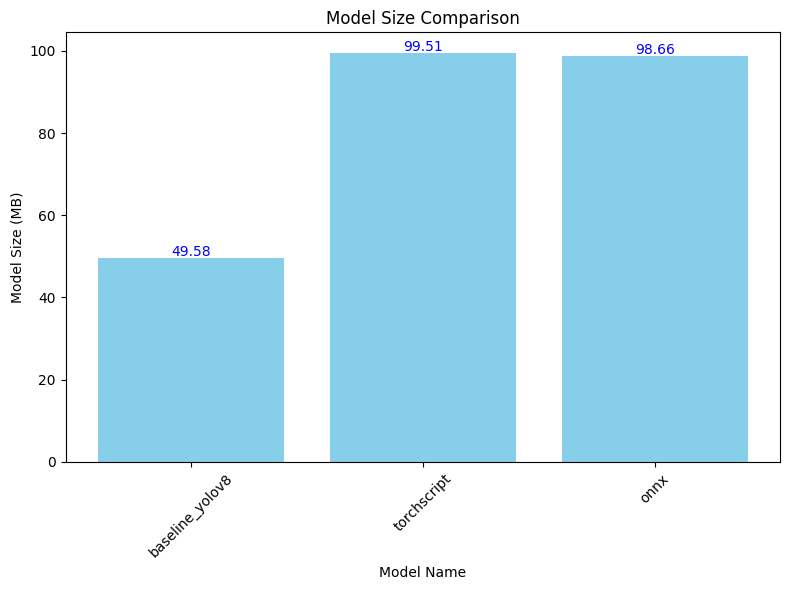

In [95]:
# Plot model name vs model size
plt.figure(figsize=(8, 6))
plt.bar(model_names, model_sizes, color='skyblue')
plt.xlabel('Model Name')
plt.ylabel('Model Size (MB)')
plt.title('Model Size Comparison')
plt.xticks(rotation=45)  # Rotate the x-axis labels if they overlap
for i, v in enumerate(model_sizes):
    plt.text(i, v + 0.5, str(v), color='blue', ha='center')
plt.tight_layout()
plt.show()


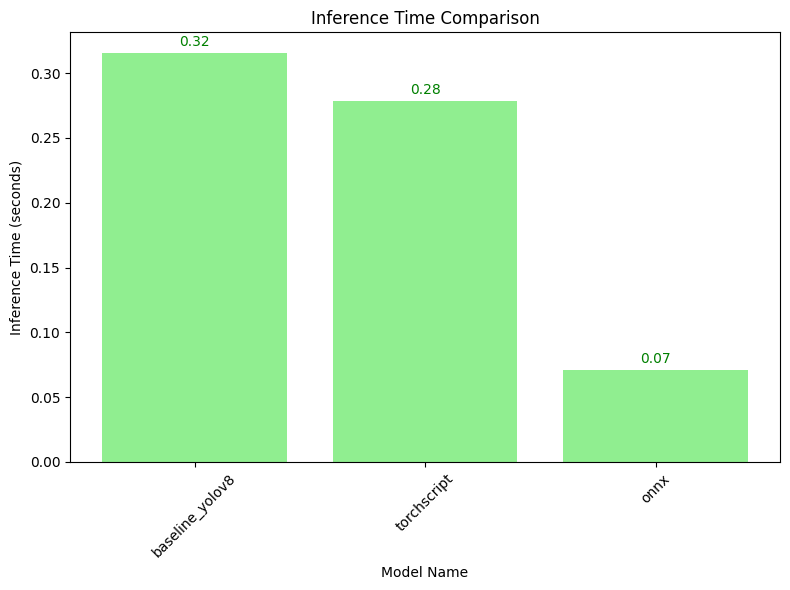

In [94]:

# Plot model name vs inference time
plt.figure(figsize=(8, 6))
plt.bar(model_names, inference_times, color='lightgreen')
plt.xlabel('Model Name')
plt.ylabel('Inference Time (seconds)')
plt.title('Inference Time Comparison')
plt.xticks(rotation=45)  # Rotate the x-axis labels if they overlap
for i, v in enumerate(inference_times):
    plt.text(i, v + 0.005, f"{v:.2f}", color='green', ha='center')
plt.tight_layout()
plt.show()